# EEE6504 - Project 1

In [46]:
import math
import time
import scipy.io
import numpy as np
from numpy import random
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.stats import levy_stable
from IPython.lib.display import Audio
from statsmodels.graphics.tsaplots import plot_acf

In [52]:
# Least Mean Squares filter that simulates iterative input stream
def LMS(x, d, K, epochs) :
    # find step size using signal power
    mu = 0.01*((epochs+K)/np.sum(np.square(x[0:epochs+K])))
    # initialize vectors
    w = np.array([random.random() for _ in range(K)])
    J = np.zeros(epochs)
    # steepest descent
    for index in range(epochs) :
        # define window
        x_t = x[index:index+K]
        d_t = d[index+K-1]
        # stochastic gradient descent
        e = d_t - w.T@x_t
        w = w + mu*e*x_t
        # update J for learning curve
        J[index] = np.square(e)
    # return weights and learning curve
    return w, J

# Affine projection using gradient descent and non-regularized solution
def APA1(x, d, K, L, mu) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and non-regularized solution
def APA2(x, d, K, L, mu, eps) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = w + mu*X@np.linalg.inv(X.T@X + eps*np.identity(L))@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using gradient descent and regularized solution
def APA3(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w = (1 - mu*lam)*w + mu*X@(D - X.T@w)
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

# Affine projection using newton's method and regularized solution
def APA4(x, d, K, L, mu, lam) :
    # number of iterations
    epochs = np.size(x) - L - K
    # initialize weights
    w = np.zeros(K)
    y = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    J = np.zeros(epochs)
    # iterate through data stream
    for i in range(epochs) :
        # construct input matrix
        X = np.zeros((K, L))
        for l in range(L) :
            X[:,l] = x[(i+l):(i+l+K)]
        # construct desired vector
        D = d[(i+K):(i+K+L)]
        # update weights
        w =(1 - mu)*w + mu*X@np.linalg.inv(X.T@X + lam*np.identity(L))@D
        # update traces, learning curve, and output
        w_traces[i,:] = w
        y[i] = d[i+K+L-1] - w.T@x[(i+L-1):(i+L+K-1)]
        J[i] = y[i]**2
    return w, w_traces, J, y

## Read data

In [53]:
# read matlab file
speech = scipy.io.loadmat('project1.mat')
fs = speech.get('fs')[0][0]
x = np.array(speech.get('primary')[0])
d = np.array(speech.get('reference')[0])

## 2-tap filter analysis

In [57]:
# filter data
K = 2
L = 1
mu = 0.002
# eps = 100
size = np.size(x) - L - K
w, w_traces, J, y = APA1(x, d, K, L, mu)

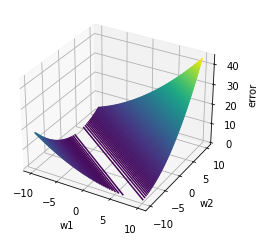

In [58]:
# plot weights performace surface contour
lag = math.floor(fs*1.5)
w1 = np.linspace(-10, 10, 1000)
w2 = np.linspace(-10, 10, 1000)
d_t = d[lag]
x_t = [x[lag-1], x[lag]]
e_t = np.zeros([1000,1000])
for i in range(1000) :
    for j in range(1000) :
        e_t[i, j] = (d_t - (w1[i]*x_t[0] + w2[j]*x_t[1]))**2
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(w1, w2, e_t, 250)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('error');

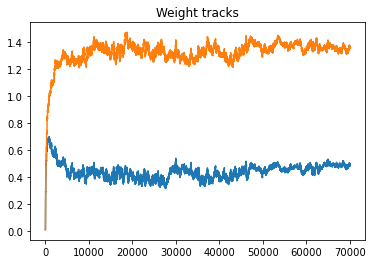

In [59]:
# plot weights track
plt.plot(np.linspace(0, size, size), w_traces[:,0])
plt.plot(np.linspace(0, size, size), w_traces[:,1])
plt.title("Weight tracks")
plt.show()

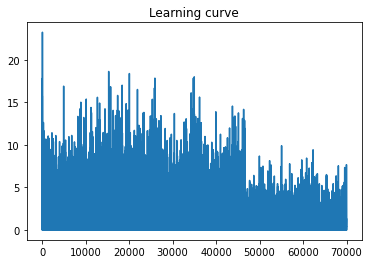

In [60]:
# plot the learning curve
plt.plot(np.linspace(0, size, size), J)
plt.title("Learning curve")
plt.show()

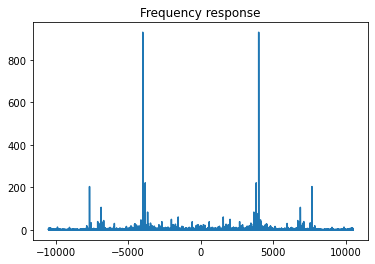

In [61]:
# estimate frequency response
y_t = np.concatenate([np.zeros(3),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("Frequency response")
plt.show()

In [62]:
# estimate SNR using ERLE
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("ERLE SNR Improvement (dB):", 10*math.log10(d_2 / y_2))

ERLE SNR Improvement (dB): 8.515659380119281


In [63]:
# output audio
Audio(y, rate=fs)

## Optimal Filter Order Analysis

In [70]:
# iterate through several filter orders to find optimal weighting
K = np.array([10, 11, 12, 13, 14])
for k in K :
    w, w_traces, J, y = APA2(x, d, k, L, mu, 10)
    y_acfk = np.correlate(y, y, mode='full')[0]
    print("ERLE SNR Improvement (dB), K =", k, ":", 10*math.log10(abs(d_acf / y_acfk)))

ERLE SNR Improvement (dB), K = 10 : 9.920493417013365
ERLE SNR Improvement (dB), K = 11 : 11.019369721647909
ERLE SNR Improvement (dB), K = 12 : 6.505338807564348
ERLE SNR Improvement (dB), K = 13 : 0.8723664260720626
ERLE SNR Improvement (dB), K = 14 : 0.5632715176829644


In [71]:
# perform APA1 with K=11
K = 11
w, w_traces, J, y = APA1(x, d, K, L, mu)

In [72]:
# output audio
Audio(y, rate=fs)

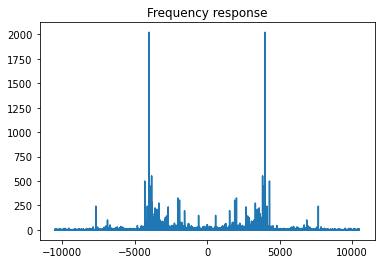

In [74]:
# estimate frequency response
y_t = np.concatenate([np.zeros(L+K),y])
d_freq = abs(np.fft.fft(d))
y_freq = abs(np.fft.fft(y_t))
H = y_freq / d_freq
plt.plot(np.linspace(-math.floor(fs/2), math.floor(fs/2), 70000), H)
plt.title("Frequency response")
plt.show()

In [73]:
# compute SNR improvement
d_acf = np.correlate(d, d, mode='full')[0]
y_acf = np.correlate(y, y, mode='full')[0]
print("ERLE SNR Improvement (dB):", 10*math.log10(abs(d_acf / y_acf)))

ERLE SNR Improvement (dB): 21.774843808213994


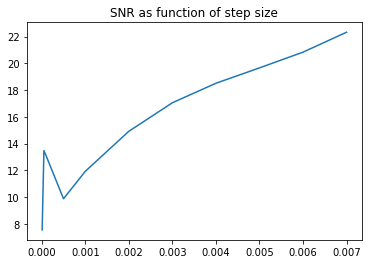

In [77]:
# evaluate performance as function of step size
mu = np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3])
ERLE = np.zeros(11)
i = 0
for m in mu :
    w, w_traces, J, y = APA2(x, d, K, L, m, 0.01)
    y_acfk = np.correlate(y, y, mode='full')[0]
    ERLE[i] = 10*math.log10(abs(d_acf / y_acfk))
    i += 1
    
# plot ERLE SNR as function of step size
plt.plot(mu, ERLE)
plt.title("SNR as function of step size")
plt.show()

In [51]:
# estimate misadjustment